# Data Demo
In this notebook we display all the data need it for the platform according to this the narrative in [this document](https://docs.google.com/document/d/18iZdwmWOiyYXQwZ1X8n87mx23nJCAjSjL9T7dXWsDLY/edit?usp=sharing).

# Setup
## Library import
We import all the required Python libraries

In [253]:
import os
import ast
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess
from dotenv import load_dotenv
import glob
from google.cloud import storage
from google.oauth2 import service_account
import ipyleaflet as ipyl

## Utils
**create_mbtiles**

In [3]:
def create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel"):
    """
    Use tippecanoe to create a MBTILE at dest_path from source_path.
    layer_name is used for the name of the layer in the MBTILE.
    Regex file path (/*.geojson) is supported for source_path.
    """
    cmd = f"tippecanoe -o {dest_path} -l {layer_name} {opts} {source_path}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
    print("Finished processing")

**mbtile_to_pbf**

In [4]:
def mbtile_to_pbf(input_mbtiles, output_path):
    """
    Use mb-util to convert mbtiles to to pbf in z/x/y.pbf form.
    To export MBTiles to disk, specify a directory that does not yet exist.
    """
    cmd = f"mb-util {input_mbtiles} {output_path} --image_format=pbf"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
    print("Finished processing")

**upload_local_directory_to_gcs**

In [6]:
def upload_local_directory_to_gcs(bucket_name, local_path, destination_blob_path):
    """Uploads a directory to the bucket."""
    
    credentials_dict = {
          "type": "service_account",
          "project_id": os.getenv("PROJECT_ID"),
         "private_key_id": os.getenv("PRIVATE_KEY_ID"),
          "private_key":os.getenv("PRIVATE_KEY"),
         "client_email": os.getenv("CLIENT_EMAIL"),
          "token_uri":os.getenv("TOKEN_URI"),   
    } 
    

    credentials = service_account.Credentials.from_service_account_info(credentials_dict)
    storage_client = storage.Client(project='project_id', credentials=credentials)
    
    bucket = storage_client.bucket(bucket_name)
    rel_paths = glob.glob(local_path + '/**', recursive=True)

    for local_file in rel_paths:
        remote_path = f'{destination_blob_path}{"/".join(local_file.split(os.sep)[len(local_path.split(os.sep))-1:])}'
        if os.path.isfile(local_file):
            blob = bucket.blob(remote_path)
            print(
                "File {} uploaded to {}.".format(
                    local_file, remote_path
                )
            )
            blob.upload_from_filename(local_file)

# Data import

## Provincias

In [206]:
provincias = gpd.read_file(f'../../datasets/raw/georegions/Provincias/Provincias.shp')
provincias.sort_values(['CO_CCAA', 'CO_PROVINC'], inplace = True)

## Comarcas Agrarias
**[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/agricultura/)**

In [8]:
comarcas_agr = gpd.read_file(f'../../datasets/raw/georegions/ComarcasAgrarias/ComarcasAgrarias.shp')
comarcas_agr.sort_values(['CO_CCAA', 'CO_PROVINC', 'CO_COMARCA'], inplace = True)

# Remove Canarias, Ceuta, and Melilla
comarcas_agr = comarcas_agr[~comarcas_agr['DS_CCAA'].isin(['Canarias', 'Ceuta', 'Melilla'])]
comarcas_agr = comarcas_agr.reset_index(drop=True)

## Municipios de España
**[Data source](https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=43.017075%2C9.288571%2C5.20)**

In [9]:
municipios = gpd.read_file(f'../../datasets/raw/georegions/Municipios/Municipios_IGN.shp')
municipios.sort_values(['CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE'], inplace = True)

# Remove Canarias, Ceuta, and Melilla
municipios = municipios[~municipios['CODNUT2'].isin(['ES70', 'ES63', 'ES64'])]
municipios = municipios.reset_index(drop=True)

## Denominaciones de Origen Protegidas
**[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/alimentacion/vinos.aspx)**

In [10]:
vinos_dop = gpd.read_file('../../datasets/raw/georegions/Vinos/calidaddiferenciada_vinos_tcm30-376469/CalidadDiferenciada_Vinos.shp')

# Remove Canarias, Ceuta, and Melilla
vinos_dop = vinos_dop[~vinos_dop['ZON_DS_NOM'].isin(['Gran Canaria', 'La Gomera', 'El Hierro',
                                                     'Valle de Güimar', 'Valle de la Orotava', 
                                                     'Abona', 'Tacoronte-Acentejo', 'Ycoden-Daute-Isora',
                                                     'La Palma', 'Lanzarote', 'Las Islas Canarias'])]
vinos_dop = vinos_dop.reset_index(drop=True)

# Data
## El riesgo climático.

### Evolución de emmisiones de GEI en España
**Read data**

In [19]:
df_historic = pd.read_csv(f'../../datasets/processed/historic_GHG_emissions_spain.csv')
df_historic

,dataset,indicator,value,year,unit
0,Historical GHG emissions,GHG emissions,8.31,1850,MtCO₂e
1,Historical GHG emissions,GHG emissions,8.37,1851,MtCO₂e
2,Historical GHG emissions,GHG emissions,8.45,1852,MtCO₂e
3,Historical GHG emissions,GHG emissions,8.63,1853,MtCO₂e
4,Historical GHG emissions,GHG emissions,8.58,1854,MtCO₂e
...,...,...,...,...,...
164,Historical GHG emissions,GHG emissions,314.95,2014,MtCO₂e
165,Historical GHG emissions,GHG emissions,325.51,2015,MtCO₂e
166,Historical GHG emissions,GHG emissions,315.83,2016,MtCO₂e
167,Historical GHG emissions,GHG emissions,332.17,2017,MtCO₂e


In [20]:
df_projected = pd.read_csv(f'../../datasets/processed/projected_GHG_emissions_spain.csv')
df_projected

,dataset,indicator,scenario,value,year,unit
0,Projected GHG emissions,GHG emissions,WeW,314.52851,2019,MtCO₂e
1,Projected GHG emissions,GHG emissions,WeW,313.92119,2020,MtCO₂e
2,Projected GHG emissions,GHG emissions,WeW,311.80261,2025,MtCO₂e
3,Projected GHG emissions,GHG emissions,WeW,298.77812,2030,MtCO₂e
4,Projected GHG emissions,GHG emissions,WeW,284.83662,2035,MtCO₂e
5,Projected GHG emissions,GHG emissions,WeW,275.64184,2040,MtCO₂e
6,Projected GHG emissions,GHG emissions,WaW,314.52851,2019,MtCO₂e
7,Projected GHG emissions,GHG emissions,WaW,308.02076,2020,MtCO₂e
8,Projected GHG emissions,GHG emissions,WaW,270.09120,2025,MtCO₂e
9,Projected GHG emissions,GHG emissions,WaW,223.53546,2030,MtCO₂e


**Display data**

Text(0, 0.5, 'Emisiones (MtCO₂e)')

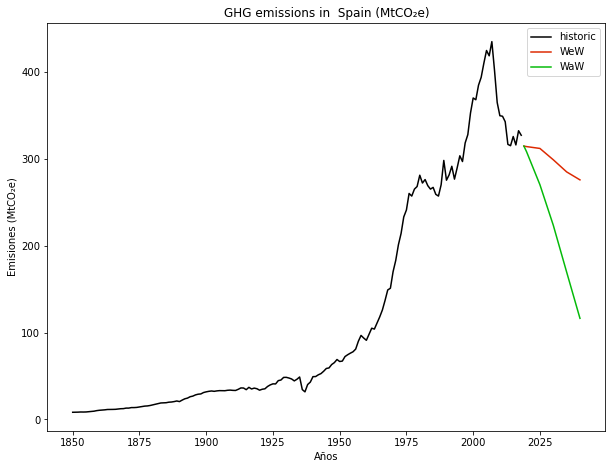

In [218]:
fig, ax = plt.subplots(figsize=(10,7.5))

df_historic.plot(ax = ax, x='year', y='value', label='historic', color='k')
df_projected[df_projected['scenario'] == 'WeW'].plot(ax = ax, x='year', y='value', label='WeW', color = '#DD2901')
df_projected[df_projected['scenario'] == 'WaW'].plot(ax = ax, x='year', y='value', label='WaW', color = '#04BA09')

ax.legend()
ax.set_title('GHG emissions in  Spain (MtCO₂e)')
ax.set_xlabel('Años')
ax.set_ylabel('Emisiones (MtCO₂e)')

### Evolución de temperatura en España
**Read data**

In [122]:
df = pd.read_csv(f'../../datasets/processed/annual_average_temperature_spain.csv')
df

,dataset,indicator,scenario,value,year,unit
0,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.414892,1986,ºC
1,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.449820,1987,ºC
2,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.469776,1988,ºC
3,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.468558,1989,ºC
4,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.488308,1990,ºC
...,...,...,...,...,...,...
195,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.125927,2081,ºC
196,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.172420,2082,ºC
197,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.234040,2083,ºC
198,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.290306,2084,ºC


**Display data**

Text(0, 0.5, 'Temperatura (ºC)')

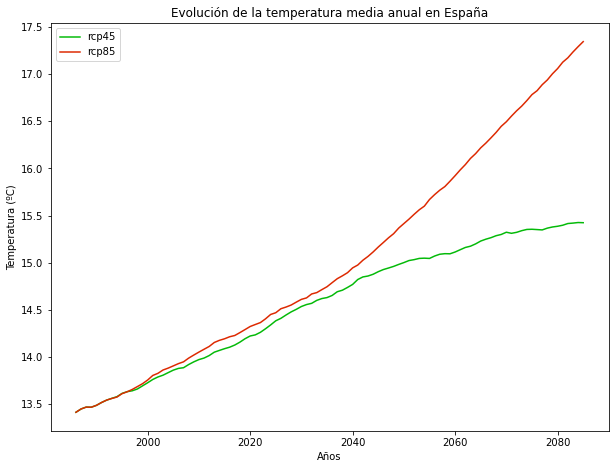

In [95]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.plot(df[df['scenario'] == 'rcp45']['year'], df[df['scenario'] == 'rcp45']['value'], label='rcp45', color = '#04BA09')
ax.plot(df[df['scenario'] == 'rcp85']['year'], df[df['scenario'] == 'rcp85']['value'], label='rcp85', color = '#DD2901')

# call with no parameters
ax.legend()
ax.set_title('Evolución de la temperatura media anual en España')
ax.set_xlabel('Años')
ax.set_ylabel('Temperatura (ºC)')

### Aumento de temperaturas proyectadas por municipio
**Read data**

In [88]:
indicator = 'mean_Tmean_Yearly_change'
scenario = 'rcp85'
year = '2065 - 2095'

In [89]:
df = pd.read_csv('../../datasets/processed/climate_indicators_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
unit = gdf['unit'].iloc[0]
gdf.head()

,CODIGOINE,dataset,indicator,scenario,value,year,unit,geometry
0,15001,Temperature statistics and heat waves,mean_Tmean_Yearly_change,rcp85,2.890699,2065 - 2095,ºC,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764..."
1,15002,Temperature statistics and heat waves,mean_Tmean_Yearly_change,rcp85,2.952255,2065 - 2095,ºC,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872..."
2,15003,Temperature statistics and heat waves,mean_Tmean_Yearly_change,rcp85,2.946671,2065 - 2095,ºC,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299..."
3,15004,Temperature statistics and heat waves,mean_Tmean_Yearly_change,rcp85,2.734466,2065 - 2095,ºC,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43..."
4,15005,Temperature statistics and heat waves,mean_Tmean_Yearly_change,rcp85,2.689627,2065 - 2095,ºC,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43..."


**Map**

Text(0.5, 1.0, 'time = 2065 - 2095, scenario = rcp85')

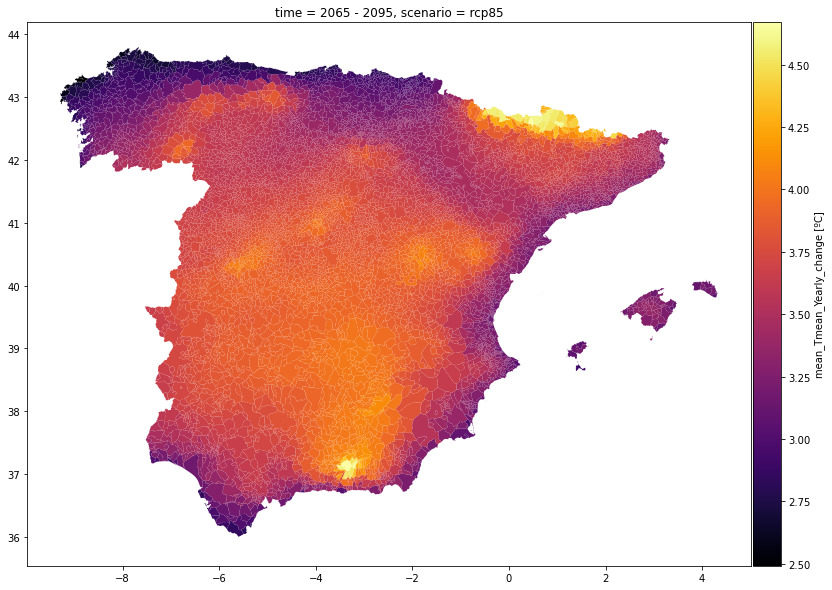

In [90]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='inferno', legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')
#plt.savefig('temp_change.svg',dpi=300)  
#plt.savefig('temp_change.png',dpi=300)

**Tooltip**

In [91]:
gdf_tool = df[(df['indicator'] == indicator) & (df['scenario'] == scenario)]

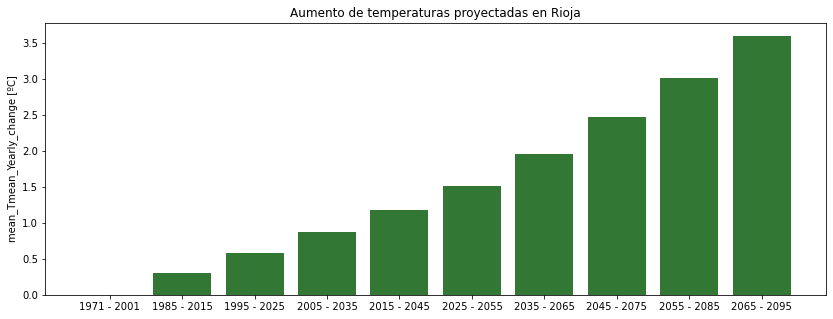

In [93]:
# Data
categories = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].year)
values = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].value)

plt.figure(figsize=(14,5))

# Plot
plt.bar(categories, values, color = "#337735")
 
plt.title('Aumento de temperaturas proyectadas en Rioja')
plt.ylabel(f'{indicator} [{unit}]')

plt.show()

### Duración de las sequías
**Read data**

In [311]:
indicator = 'dry-spells_maximum-length'
scenario = 'rcp85'
year = '2081 - 2100'

In [312]:
df = pd.read_csv('../../datasets/processed/climate_indicators_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
unit = gdf['unit'].iloc[0]
gdf.head()

,CODIGOINE,dataset,indicator,scenario,value,year,unit,geometry
0,15001,Bioclimatic indicators,dry-spells_maximum-length,rcp85,47.804245,2081 - 2100,days,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764..."
1,15002,Bioclimatic indicators,dry-spells_maximum-length,rcp85,46.572353,2081 - 2100,days,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872..."
2,15003,Bioclimatic indicators,dry-spells_maximum-length,rcp85,44.020634,2081 - 2100,days,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299..."
3,15004,Bioclimatic indicators,dry-spells_maximum-length,rcp85,50.300858,2081 - 2100,days,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43..."
4,15005,Bioclimatic indicators,dry-spells_maximum-length,rcp85,50.229847,2081 - 2100,days,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43..."


**Map**

Text(0.5, 1.0, 'time = 2081 - 2100, scenario = rcp85')

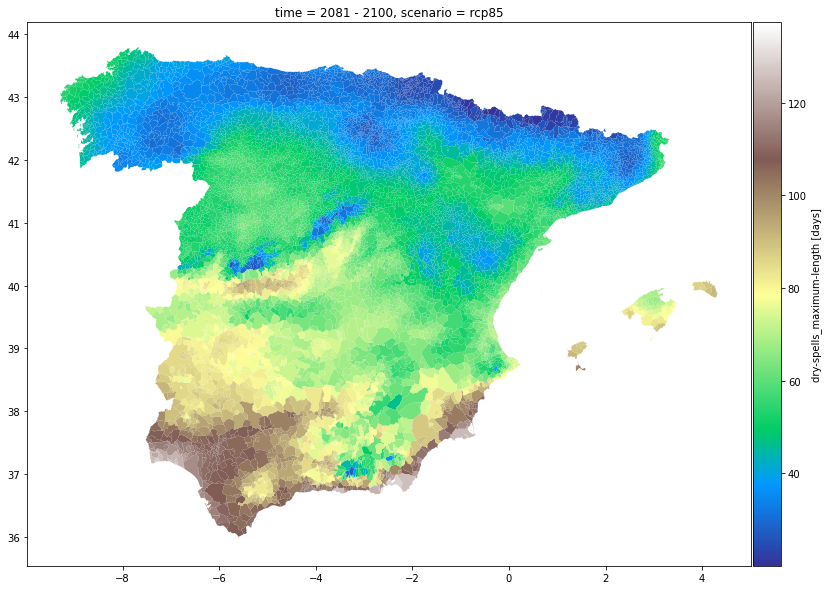

In [313]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='terrain', legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

**Tooltip**

In [314]:
gdf_tool = df[(df['indicator'] == indicator) & (df['scenario'] == scenario)]

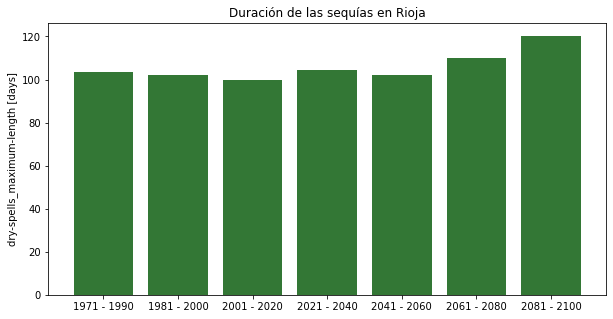

In [315]:
# Data
categories = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].year)
values = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].value)

plt.figure(figsize=(10,5))

# Plot
plt.bar(categories, values, color = "#337735")
 
plt.title('Duración de las sequías en Rioja')
plt.ylabel(f'{indicator} [{unit}]')

plt.show()

## El riesgo agrícola.

### Evolución de la producción agrícola española en el tiempo por tipo de cultivo.
**Read data**

In [224]:
df_pro = pd.read_csv('../../datasets/processed/serie_historica_produccion_agricola_española.csv')
df_pro.head()

,dataset,indicator,value,year,unit
0,Serie histórica de producción agrícola española,Producción de cereales grano,24567.000,2000,kt
1,Serie histórica de producción agrícola española,Producción de cereales grano,18055.000,2001,kt
2,Serie histórica de producción agrícola española,Producción de cereales grano,21682.715,2002,kt
3,Serie histórica de producción agrícola española,Producción de cereales grano,21170.000,2003,kt
4,Serie histórica de producción agrícola española,Producción de cereales grano,24848.632,2004,kt


**Display data**

Text(0, 0.5, 'Producción (kt)')

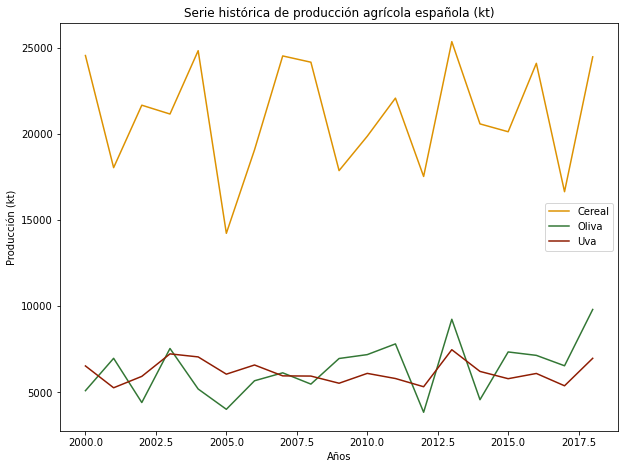

In [225]:
fig, ax = plt.subplots(figsize=(10,7.5))

df_pro[df_pro['indicator'] == 'Producción de cereales grano'].plot(ax = ax, x='year', y='value', label='Cereal', color = '#DD9201')
df_pro[df_pro['indicator'] == 'Producción de aceituna'].plot(ax = ax, x='year', y='value', label='Oliva', color = '#337735')
df_pro[df_pro['indicator'] == 'Producción de uva'].plot(ax = ax, x='year', y='value', label='Uva', color = '#8F1D03')

ax.legend()
ax.set_title('Serie histórica de producción agrícola española (kt)')
ax.set_xlabel('Años')
ax.set_ylabel('Producción (kt)')

### Mapa de cultivos
**Read data**

In [82]:
gdf_corine = gpd.read_file('../../datasets/raw/crops/CLC2018_GDB/CLC2018_ES.gdb', driver="FileGDB", layer='CLC18_ES')
# Re-Project
gdf_corine = gdf_corine.to_crs("EPSG:4326")
gdf_corine = gdf_corine.set_crs("EPSG:4326")

**Reorganice data**

In [203]:
dic = {'Cereal': ['211', '212'],
'Olivar': ['223'],
'Dehesa': ['244'],
'Viñedo': ['221']}

gdf = gpd.GeoDataFrame(columns=['ID', 'value', 'geometry'])

for crop in dic.keys():
    print(crop)
    gdf_tmp = gdf_corine[gdf_corine['CODE_18'].isin(dic[crop])].copy()
    gdf_tmp['value'] = crop
    gdf_tmp = gdf_tmp[['ID', 'value', 'geometry']]
    
    gdf  = pd.concat([gdf, gdf_tmp])

gdf['dataset'] = 'Mapa de cultivos'
gdf['indicator'] = 'Localización cultivo'

gdf = gdf[['ID', 'dataset', 'indicator', 'value', 'geometry']]

gdf_corine = gdf
gdf_corine .head()

Cereal
Olivar
Dehesa
Viñedo


,ID,dataset,indicator,value,geometry
16379,16382,Mapa de cultivos,Localización cultivo,Cereal,"MULTIPOLYGON (((-5.64246 36.12721, -5.64226 36..."
16380,16383,Mapa de cultivos,Localización cultivo,Cereal,"MULTIPOLYGON (((-5.50050 36.17831, -5.50045 36..."
16381,16384,Mapa de cultivos,Localización cultivo,Cereal,"MULTIPOLYGON (((-5.50964 36.18659, -5.50953 36..."
16382,16385,Mapa de cultivos,Localización cultivo,Cereal,"MULTIPOLYGON (((-5.69228 36.18296, -5.69232 36..."
16383,16386,Mapa de cultivos,Localización cultivo,Cereal,"MULTIPOLYGON (((-5.46238 36.20897, -5.46238 36..."


**Display data**

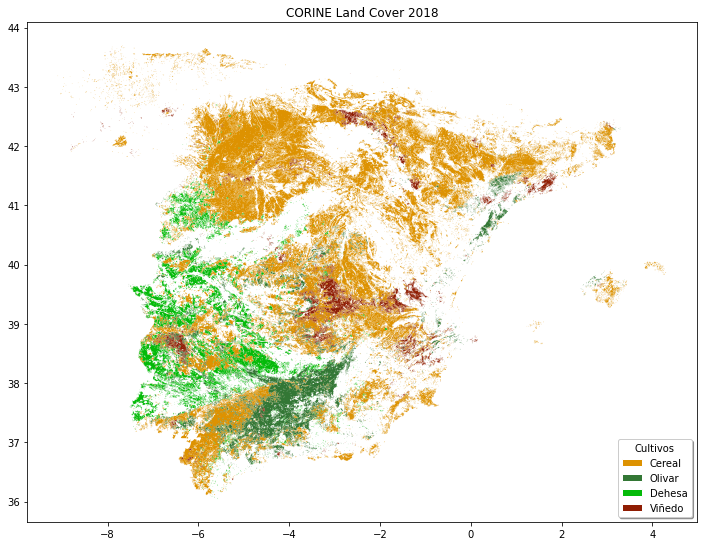

In [204]:
fig, ax = plt.subplots(figsize=(12,12))

gdf_corine[gdf_corine['value'] == 'Cereal'].plot(ax=ax, color='#DD9201', label= 'Cereal', legend=True)
gdf_corine[gdf_corine['value'] == 'Olivar'].plot(ax=ax, color='#337735', label= 'Olivar', legend=True)
gdf_corine[gdf_corine['value'] == 'Dehesa'].plot(ax=ax, color='#04BA09', label= 'Dehesa', legend=True)
gdf_corine[gdf_corine['value'] == 'Viñedo'].plot(ax=ax, color='#8F1D03', label= 'Viñedo', legend=True)

ax.set_title('CORINE Land Cover 2018')

# Adding custom legend
pmark1 = mpatches.Patch(facecolor='#DD9201',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Cereal')

pmark2 = mpatches.Patch(facecolor='#337735',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Olivar')

pmark3 = mpatches.Patch(facecolor='#04BA09',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Dehesa')

pmark4 = mpatches.Patch(facecolor='#8F1D03',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Viñedo')

handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=[
        *handles,
        pmark1,
        pmark2,
        pmark3,
        pmark4,
    ],
    title="Cultivos",
    loc='lower right',
    ncol=1,
    shadow=True)

# show figure
plt.rcParams['legend.title_fontsize'] = 10
plt.show()

## Olivar
### Superficie de olivar
**Display data**

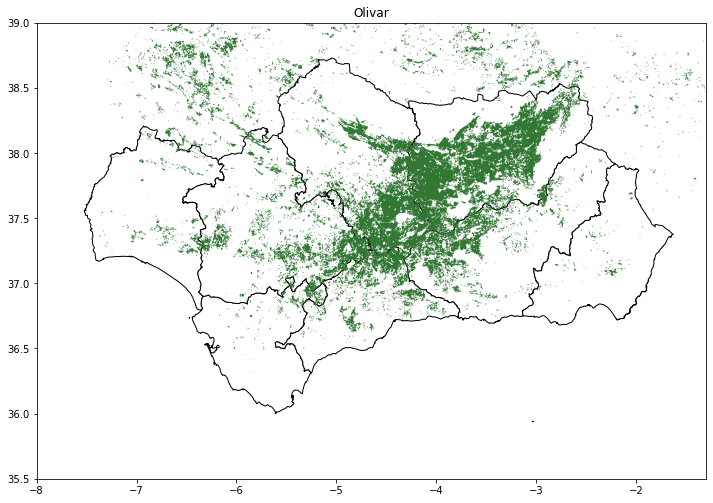

In [216]:
fig, ax = plt.subplots(figsize=(12,12))

provincias[provincias['DS_CCAA'] == 'Andalucía'].plot(ax=ax, color='w', edgecolor='k')
gdf_corine[gdf_corine['value'] == 'Olivar'].plot(ax=ax, color='#337735', label= 'Olivar', legend=True)

ax.set_title('Olivar')
ax.set_ylim([35.5,39]);
ax.set_xlim([-8,-1.3]);

### Cambios en zonas óptimas para el cultivo de olivo.
**Display tiles**

In [446]:
center = (38, -5)
m = ipyl.Map(center=(center), zoom=6)

m.add_layer(ipyl.TileLayer(
    url='https://storage.googleapis.com/ecf-agricultural-climate-impact/RasterTiles/olivar/Arenas_Castro/1961_2000/{z}/{x}/{y}.png',
    layers='olivar',
    format='image/png',
    name='olivar',
    opacity=1
))

control = ipyl.LayersControl(position='topright')
m.add_control(control)
m.add_control(ipyl.FullScreenControl())
m

Map(center=[38, -5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Proyecciones de rendimiento del olivo.
**Read data**

In [255]:
indicator = 'yield_change_per'
scenario = 'rcp85'
year = '2041–2070'

df = pd.read_csv('../../datasets/processed/olivar/yield_change_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
unit = gdf['unit'].iloc[0]
gdf.head()

,CODIGOINE,dataset,indicator,scenario,value,year,unit,geometry
0,15001,Olivar,yield_change_per,rcp85,NaN,2041–2070,%,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764..."
1,15002,Olivar,yield_change_per,rcp85,NaN,2041–2070,%,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872..."
2,15003,Olivar,yield_change_per,rcp85,NaN,2041–2070,%,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299..."
3,15004,Olivar,yield_change_per,rcp85,NaN,2041–2070,%,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43..."
4,15005,Olivar,yield_change_per,rcp85,NaN,2041–2070,%,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43..."


**Map**

Text(0.5, 1.0, 'Yield change [time = 2041–2070, scenario = rcp85]')

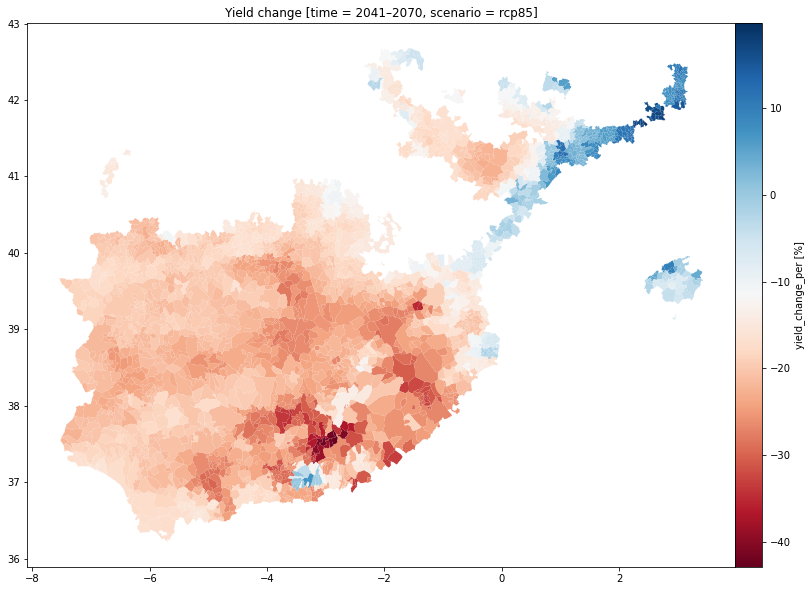

In [257]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='RdBu', legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'Yield change [time = {year}, scenario = {scenario}]')

## Cereales
### Superficie destinada al cultivo de cereales
**Display data**

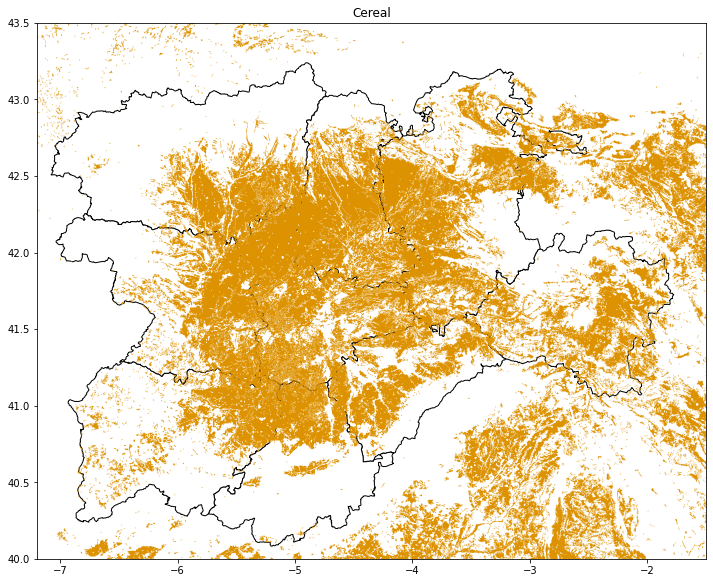

In [450]:
fig, ax = plt.subplots(figsize=(12,12))

provincias[provincias['DS_CCAA'] == 'Castilla y León'].plot(ax=ax, color='w', edgecolor='k')
gdf_corine[gdf_corine['value'] == 'Cereal'].plot(ax=ax, color='#DD9201', label= 'Cereal', legend=True)

ax.set_title('Cereal')
ax.set_ylim([40,43.5]);
ax.set_xlim([-7.2,-1.5]);

## Otros

### Emisiones por municipio
**Read data**

In [11]:
df = pd.read_csv('../../datasets/processed/CO2_emissions_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[df['indicator'] == 'CO2_emissions'].astype({'value': 'float64'})
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
gdf.head()

,CODIGOINE,dataset,indicator,scenario,value,year,unit,geometry
0,15001,OpenGHGMap,CO2_emissions,NaN,165448.0,2018,t,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764..."
1,15002,OpenGHGMap,CO2_emissions,NaN,43288.0,2018,t,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872..."
2,15003,OpenGHGMap,CO2_emissions,NaN,64922.0,2018,t,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299..."
3,15004,OpenGHGMap,CO2_emissions,NaN,85412.0,2018,t,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43..."
4,15005,OpenGHGMap,CO2_emissions,NaN,1117753.0,2018,t,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43..."


**Map**

Text(0.5, 1.0, 'Emisiones de CO2 por municipio [t CO2]')

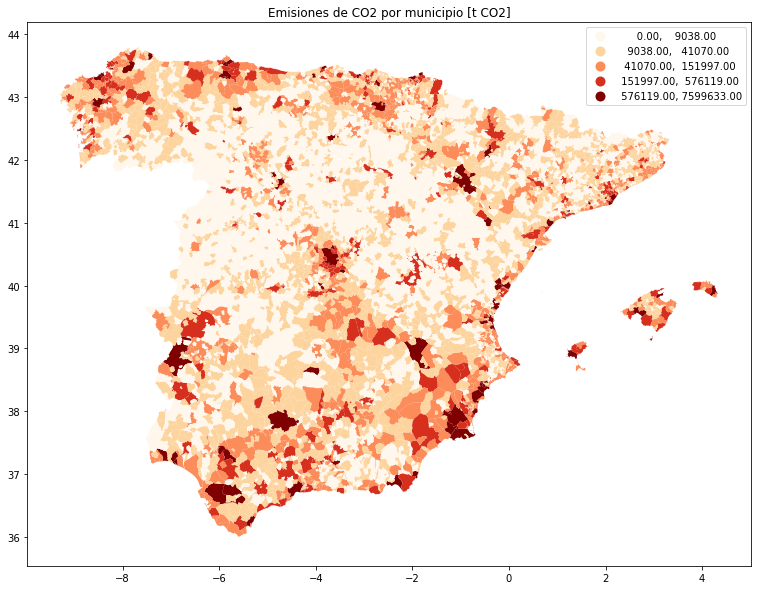

In [12]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

gdf.plot(ax=ax, column='value', cmap='OrRd', scheme='jenkscaspall', legend=True)
ax.set_title('Emisiones de CO2 por municipio [t CO2]')
#plt.savefig('emissions.svg',dpi=300)  
#plt.savefig('emissions.png',dpi=300)

**Tooltip**

In [13]:
df_cat = df[df['indicator'] == 'emissions_by_category']
df_cat = gpd.GeoDataFrame(pd.merge(df_cat, municipios[['CODIGOINE', 'NAMEUNIT']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
cats = ast.literal_eval(df_cat[df_cat['NAMEUNIT'] == 'Málaga']['value'].iloc[0])

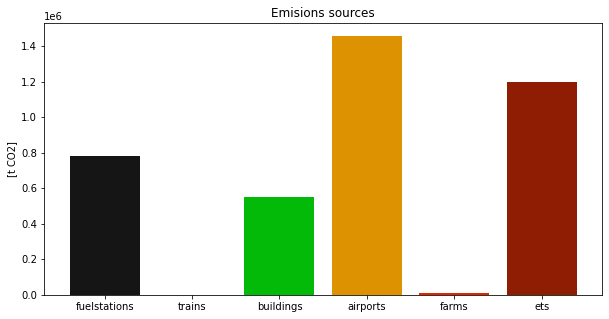

In [14]:
# Data
categories = list(cats.keys())
values = list(cats.values())
c = ["#151515", "#337735", "#04BA09", "#DD9201", "#DD2901", "#8F1D03"]

plt.figure(figsize=(10,5))

# Plot
plt.bar(categories, values, color = c)
 
plt.title('Emisions sources')
plt.ylabel('[t CO2]')

plt.show()

## Población dependiente de agricultura
**Read data**

In [ ]:
df = pd.read_csv(f'../../datasets/processed/población_activa.csv')
gdf = pd.merge(provincias.astype({'CO_CCAA': int, 'CO_PROVINC': int}), df, how='left', on=['CO_CCAA','CO_PROVINC'])
gdf.head()

**Display data**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1) 

gdf.plot(ax=ax, column='value', cmap='gist_earth', edgecolor='grey', legend=True, cax=cax, legend_kwds={'label': 'Porcentage de población activa [%]'})
ax.set_title('Población dependiente de agricultura')

## Precipitación durante el trimestre más húmedo

To compute the total precipitation sum over the month, a conversion factor should be applied of 3600x24x91.3 (average number of days per quarter)*1000  (mm month-1).

**Read data**

In [ ]:
conversion_factor = 3600*24*91.3*1000

In [ ]:
indicator = 'BIO16'
scenario = 'rcp85'
year = '2081 - 2100'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
unit = gdf['unit'].iloc[0]
# From m/s to mm/month
gdf['value'] = gdf['value'].apply(lambda x: x*conversion_factor)
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='Blues', edgecolor='grey', linewidth=0.2, legend=True, cax=cax, legend_kwds={'label': f'{indicator} [mm/month]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

**Tooltip**

In [ ]:
gdf_tool = df[(df['indicator'] == indicator) & (df['scenario'] == scenario)]

In [ ]:
# Data
categories = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].year)
values = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].value)

plt.figure(figsize=(10,5))

# Plot
plt.bar(categories, (np.array(values)*conversion_factor), color = "#337735")
 
plt.title('Precipitación durante el trimestre más húmedo en Rioja')
plt.ylabel(f'{indicator} [mm/month]')

plt.show()

# Viñedo
## Mapa de zonificación
**Read data**

In [ ]:
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')
gdf_grid = gpd.read_file('../../datasets/processed/rejilla_viñedos.geojson')  
df_zone = pd.read_csv(f'../../datasets/processed/zonas_alto_potencial_climático_viñedos.csv')

gdf_zone = gpd.GeoDataFrame(pd.merge(df_zone, gdf_grid, how='left', on='DENOMINACI'))

**Display data**

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

plt.rc('axes', titlesize=20) 

spain.plot(ax=ax1, color='w', edgecolor='k')
vinos_dop.plot(ax=ax1, color='w', edgecolor='k')
gdf_zone[(gdf_zone['scenario'] == 'baseline') & (gdf_zone['year'] == '1971-2000')].plot(ax=ax1, column='value', alpha=.9)
ax1.set_title('1971-2000')
ax1.axis('off')

spain.plot(ax=ax2, color='w', edgecolor='k')
vinos_dop.plot(ax=ax2, color='w', edgecolor='k')
gdf_zone[(gdf_zone['scenario'] == 'rcp45') & (gdf_zone['year'] == '2021-2050')].plot(ax=ax2, column='value', alpha=.9)
vinos_dop.plot(ax=ax2, color='w', edgecolor='k', alpha=0.1)
ax2.set_title('2021-2050')
ax2.axis('off')

## Duración de las olas de calor
**Read data**

In [ ]:
indicator = 'HWD_EU_climate'
scenario = 'rcp85'
year = '2065 - 2095'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_denominaciones_de_origen_protegidas.csv')
df = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(df, vinos_dop[['OBJECTID', 'geometry']], how='left', on='OBJECTID'))
unit = gdf['unit'].iloc[0]
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='gist_heat_r', edgecolor='grey', linewidth=0.2, legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

## Duración de las sequías
**Read data**

In [310]:
indicator = 'dry-spells_maximum-length'
scenario = 'rcp85'
year = '2081 - 2100'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_denominaciones_de_origen_protegidas.csv')
df = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(df, vinos_dop[['OBJECTID', 'geometry']], how='left', on='OBJECTID'))
unit = gdf['unit'].iloc[0]
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='terrain', edgecolor='grey', linewidth=0.2, legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

# Cereales
## Mapa de zonificación
**Read data**